In [4]:
import os
import json

# Load environment configuration first
def load_env_config(json_path):
    """Load and set environment variables from config file"""
    with open(json_path, 'r') as file:
        env_config = json.load(file)
    os.environ['HF_HOME'] = env_config['HF_HOME']
    os.environ['HUGGINGFACE_HUB_TOKEN'] = env_config['access_token']

# Configuration dictionary
config = {
    # Environment settings
    'env': {
        'json_path': 'env_config.json',
        'results_dir': 'results',
    },
    # Model settings
    'model': {
        'pretrained_name': 'google/vit-base-patch16-224',
        'patch_size': 14,
        'output_dim': 1000,  # ImageNet classes
    },
    # Evaluation settings
    'eval': {
        'infer_batch_size': 512,  
        'seed': 42,
    }
}

# Set environment variables before importing transformers
load_env_config(config['env']['json_path'])

from maskgen.utils import get_device, get_pred_model, load_imagenet_eval_data

device = get_device()
processor, pred_model = get_pred_model(pretrained_name=config['model']['pretrained_name'], device=device)
train_ds, val_ds, test_ds = load_imagenet_eval_data(seed=config['eval']['seed'])
mean, std = processor.image_mean, processor.image_std

Repo card metadata block was not found. Setting CardData to empty.


In [21]:
import torch
from captum.attr import GradientShap
import numpy as np
from torch import nn
import requests
from PIL import Image

class ModelWrapper(nn.Module):
    """
    Wrapper class for models that return dictionaries containing logits.
    Adapts the forward pass to be compatible with Captum's attribution methods.
    """
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        """
        Modify forward pass to return only the logits tensor instead of a dictionary.
        """
        outputs = self.model(pixel_values=x)
        return outputs.logits

def prepare_model(model):
    """
    Prepare a model for use with GradShap attribution.
    
    Args:
        model: Original model that returns dictionary with logits
        
    Returns:
        ModelWrapper: Wrapped model compatible with Captum
    """
    wrapped_model = ModelWrapper(model)
    wrapped_model.eval()  # Set to evaluation mode
    return wrapped_model

class GradShapAnalyzer:
    """
    A class to compute GradientShap attribution for a single image.
    """
    
    def __init__(
        self,
        model,
        device,
        n_samples=50,
        baseline_std=0.001,
        stdevs=0.09
    ):
        """
        Initialize the GradShapAnalyzer.
        
        Args:
            model: The prediction model
            processor: Image processor/transform
            device: Computing device (CPU/GPU)
            n_samples: Number of samples for GradientShap
            baseline_std: Standard deviation for baseline noise
            stdevs: Standard deviation for GradientShap
        """
        # Prepare model for attribution
        self.model = prepare_model(model).to(device)
        self.device = device
        self.n_samples = n_samples
        self.baseline_std = baseline_std
        self.stdevs = stdevs
        
        # Initialize GradientShap with wrapped model
        self.gradient_shap = GradientShap(self.model)
    
    def _prepare_baseline(self, input_shape):
        """Create baseline input for GradientShap."""
        return torch.randn(1, *input_shape) * self.baseline_std
    
    def get_attribution(self, pixel_values, target_class=None):
        """
        Compute GradientShap attribution scores for a single image.
        
        Args:
            image: Input image
            target_class: Optional target class index. If None, uses model's prediction
        
        Returns:
            tuple: (attribution_map, predicted_class, prediction_confidence)
        """
        # Process image
        pixel_values = pixel_values.to(self.device)
        
        # Get prediction if target class not provided
        if target_class is None:
            with torch.no_grad():
                output = self.model(pixel_values)
                predicted_class = output.argmax(dim=1).item()
                confidence = torch.softmax(output, dim=1).max().item()
                target_class = predicted_class
        else:
            predicted_class = target_class
            confidence = None
        
        # Create baseline
        baseline = self._prepare_baseline(pixel_values.shape[1:]).to(self.device)
        
        # Compute attribution
        attribution = self.gradient_shap.attribute(
            pixel_values,
            baselines=baseline,
            target=target_class,
            n_samples=self.n_samples,
            stdevs=self.stdevs
        )
        
        # Convert to numpy array
        attribution_map = attribution.squeeze().cpu().detach().numpy()
        
        return attribution_map, predicted_class, confidence
    
    def get_top_regions(self, attribution_map, top_k=5):
        """
        Find the top-k most important regions in the attribution map.
        
        Args:
            attribution_map: Attribution scores
            top_k: Number of top regions to return
            
        Returns:
            tuple: (indices of top regions, corresponding importance scores)
        """
        # Compute absolute values
        abs_attr = np.abs(attribution_map)
        flat_attr = abs_attr.reshape(-1)
        
        # Get top-k indices and scores
        top_k_idx = np.argsort(flat_attr)[-top_k:]
        importance_scores = flat_attr[top_k_idx]
        
        return top_k_idx, importance_scores

# Example usage
if __name__ == "__main__":
    from torch.utils.data import DataLoader, Subset
    # url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    # url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
    # url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
    url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
    image = Image.open(requests.get(url, stream=True).raw)
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values.to(device)
    
    # Initialize analyzer with wrapped model
    analyzer = GradShapAnalyzer(
        model=pred_model,
        device=device
    )
    
    # Get attribution for single image
    attribution_map, pred_class, confidence = analyzer.get_attribution(pixel_values)
    
    print(f"Predicted class: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

Predicted class: 207
Confidence: 0.897


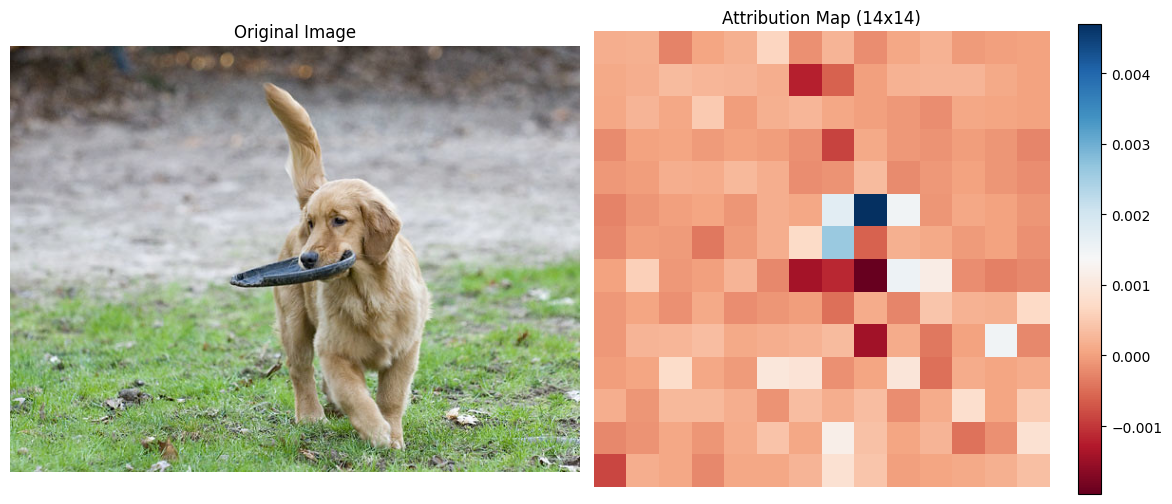

In [25]:
import matplotlib.pyplot as plt

def downsample_attribution(attribution_map, patch_size=16):
    """
    Downsample attribution map by averaging patches of size patch_size x patch_size.
    
    Args:
        attribution_map: Attribution scores (C,H,W)
        patch_size: Size of patches to average (default: 16)
    Returns:
        Downsampled attribution map
    """
    # Take mean across channels first
    attr_mean = attribution_map.mean(axis=0)  # (H,W)
    
    H, W = attr_mean.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    # Reshape to create patches and take mean
    downsampled = attr_mean.reshape(new_H, patch_size, new_W, patch_size).mean(axis=(1,3))
    
    return downsampled

def plot_attribution(image, attribution_map, patch_size=16):
    """
    Plot original image and downsampled attribution map side by side.
    
    Args:
        image: PIL Image
        attribution_map: Attribution scores (C,H,W)
        patch_size: Size of patches to average (default: 16)
    """
    # Convert PIL image to numpy array
    img_array = np.array(image)
    
    # Downsample attribution map
    downsampled_attr = downsample_attribution(attribution_map, patch_size)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot original image
    ax1.imshow(img_array)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Plot downsampled attribution map
    attr_plot = ax2.imshow(downsampled_attr, cmap='RdBu')
    ax2.set_title(f'Attribution Map ({downsampled_attr.shape[0]}x{downsampled_attr.shape[1]})')
    ax2.axis('off')
    
    # Add colorbar
    plt.colorbar(attr_plot, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_attribution(image, attribution_map)

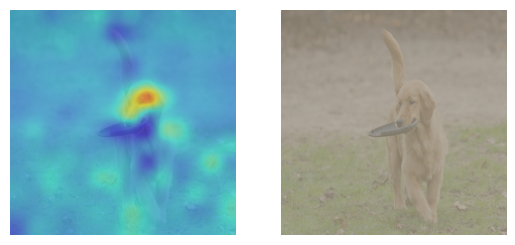

In [37]:
from maskgen.utils.img_utils import plot_overlap_np
# Define image normalization parameters (these should match your processor's normalization)
img_mean = [0.485, 0.456, 0.406]  # ImageNet mean
img_std = [0.229, 0.224, 0.225]   # ImageNet std

# Convert image to numpy array format if it's a PIL image
if isinstance(image, Image.Image):
    image = image.resize((224, 224))  # Resize to model input size
    image_np = np.array(image) / 255.0  # Convert to CHW format and normalize to [0,1]

# Take mean across channels for attribution map and reshape to 14x14
attr_mean = attribution_map.mean(axis=0)  # Average across channels
# Properly downsample to 14x14 by reshaping and taking mean
h, w = attr_mean.shape
patch_size = h // 14
downsampled_attr = attr_mean.reshape(14, patch_size, 14, patch_size).mean(axis=(1, 3))
# Plot using plot_overlap_np
image_vis, heatmap_vis = plot_overlap_np(
    image=image_np,          # Should be in CHW format, [0,1] range
    heatmap=downsampled_attr,  # Your 14x14 attribution map
    img_mean=img_mean,
    img_std=img_std
)

In [36]:
image_np.shape

(3, 224, 224)

In [18]:

# Example usage
if __name__ == "__main__":
    # url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    # url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
    # url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
    url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
    image = Image.open(requests.get(url, stream=True).raw)
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values.to(device)
    # Assuming we have a single image, pred_model, processor, and device defined
    analyzer = GradShapAnalyzer(
        model=pred_model,
        processor=processor,
        device=device
    )
    
    # Get attribution for single image
    attribution_map, pred_class, confidence = analyzer.get_attribution(pixel_values)
    
    # # Get top important regions
    top_regions, importance_scores = analyzer.get_top_regions(attribution_map)

AttributeError: 'ImageClassifierOutput' object has no attribute 'shape'

In [14]:
with torch.no_grad():
    logits = pred_model(**inputs).logits

In [17]:
logits

tensor([[-4.7902e-01, -1.3956e+00, -4.8828e-01, -8.1899e-01,  3.7198e-01,
         -7.7799e-01, -8.8075e-01, -6.2733e-01, -9.7301e-01, -7.8661e-01,
         -7.8279e-01, -7.3580e-01, -1.0084e+00, -1.3234e+00,  6.7309e-02,
         -1.1202e+00, -1.4988e+00,  5.1112e-01,  2.7508e-01, -3.9023e-01,
         -4.3380e-01, -1.1721e-01, -4.6105e-01, -5.7130e-01, -3.0222e-01,
         -1.4792e+00, -8.1640e-01, -1.1708e+00, -9.0249e-01, -2.0207e+00,
         -1.1584e+00, -1.6156e+00, -1.1065e+00, -1.4559e+00, -5.7002e-01,
         -1.8074e+00, -1.7726e+00, -2.0421e+00, -1.6134e+00, -1.7859e+00,
         -6.5125e-01, -1.2823e+00, -1.7176e+00, -1.9928e+00, -1.1332e+00,
         -1.8132e+00, -1.3275e+00, -6.9631e-01, -1.2511e+00, -1.2302e+00,
         -8.9514e-01, -1.9614e-01, -2.4785e-01, -2.6439e-01, -1.1499e+00,
         -1.3522e+00, -9.0151e-01, -8.2314e-01, -7.4613e-01, -9.9437e-01,
          1.2064e-01, -5.9625e-01, -1.4239e-01, -1.3756e+00, -1.1839e+00,
         -2.4719e-01, -6.5558e-01,  2.